In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
train_folder = '/kaggle/input/intel-image-classification/seg_train/seg_train/'

In [3]:
import os

In [4]:
#find number of files in train folder
n = 0
for _, _, filenames in os.walk(train_folder):
    for filename in filenames:
        n += 1

In [5]:
n

14034

In [6]:
ds_filelist_train = tf.data.Dataset.list_files(file_pattern = train_folder + '*/*', shuffle = False)

In [7]:
ds_filelist_train = ds_filelist_train.shuffle(buffer_size = n, reshuffle_each_iteration = False)

In [8]:
table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(tf.constant(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']), tf.range(6)), -1)
def load_imgs(filepath):
    img = tf.io.read_file(filepath)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [150, 150])
    
    tag = tf.strings.split(filepath, os.path.sep)[-2]

    label = table.lookup(tag)
    
    return img, label

In [9]:
ds_train = ds_filelist_train.map(load_imgs, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [10]:
def img_augmentation(img, label):
    #img = tf.image.random_contrast(img, 0.1, 0.9)
    #img = tf.image.random_hue(img, 0.5)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_crop(img, (125, 125, 3))
    return tf.image.resize(img, (150, 150)), label

In [11]:
ds_train = ds_train.map(img_augmentation, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [12]:
for i in ds_train.take(1):
    print(i)

(<tf.Tensor: shape=(150, 150, 3), dtype=float32, numpy=
array([[[0.9450981 , 0.9921569 , 0.9843138 ],
        [0.9509804 , 0.99803925, 0.9843138 ],
        [0.95294124, 1.        , 0.9843138 ],
        ...,
        [0.9333334 , 0.9960785 , 0.9921569 ],
        [0.932353  , 0.99705887, 0.9941177 ],
        [0.9294118 , 1.        , 1.        ]],

       [[0.9392158 , 0.9950981 , 0.9843138 ],
        [0.9428922 , 0.9987745 , 0.9865197 ],
        [0.9458334 , 1.        , 0.9855393 ],
        ...,
        [0.9362746 , 0.9990196 , 0.9950981 ],
        [0.93455887, 0.9992647 , 0.9963236 ],
        [0.9294118 , 1.        , 1.        ]],

       [[0.9418301 , 0.9937909 , 0.9843138 ],
        [0.9447713 , 0.99673206, 0.987255  ],
        [0.94803923, 0.99904686, 0.9859478 ],
        ...,
        [0.9349674 , 0.99771243, 0.9937909 ],
        [0.9330066 , 0.99771243, 0.9947713 ],
        [0.92712426, 0.99771243, 0.99771243]],

       ...,

       [[0.37026143, 0.37026143, 0.3624183 ],
        [0.3

In [13]:
#Build the CNN Model
model = tf.keras.Sequential() #input (150, 150, 3)
model.add(tf.keras.layers.Conv2D(filters = 27, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (150, 150, 3))) #result in (150, 150, 27)
model.add(tf.keras.layers.MaxPool2D(pool_size = 5)) #result in (30, 30, 27)
model.add(tf.keras.layers.Dropout(0.2)) #Drop out prob 20%
model.add(tf.keras.layers.Conv2D(filters = 54, kernel_size = 5, padding = 'same')) #result in (30, 30, 54)
model.add(tf.keras.layers.MaxPool2D(pool_size = 5)) #result in (6, 6, 54)
model.add(tf.keras.layers.Flatten()) #Flatten to 6 * 6 * 54
model.add(tf.keras.layers.Dense(100, activation = 'relu')) # 100
model.add(tf.keras.layers.Dropout(0.5)) #Drop out prob 50%
model.add(tf.keras.layers.Dense(6)) # number of outputs = 6

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 27)      351       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 27)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 27)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 54)        36504     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 54)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1944)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [14]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

In [15]:
#Prepare the data for training
ds_train_orig = ds_train
ds_train = ds_train_orig.take(13000)
ds_valid = ds_train_orig.skip(13000)

#shuffle, batch
ds_train = ds_train.shuffle(n).batch(20).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
ds_valid = ds_valid.batch(20).cache().prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [16]:
history = model.fit(ds_train, epochs = 20, validation_data = ds_valid)

Epoch 1/20
650/650 [==============================] - 16s 25ms/step - loss: 1.0838 - accuracy: 0.5861 - val_loss: 0.9201 - val_accuracy: 0.6557
Epoch 2/20
650/650 [==============================] - 5s 8ms/step - loss: 0.8498 - accuracy: 0.6888 - val_loss: 0.7426 - val_accuracy: 0.7340
Epoch 3/20
650/650 [==============================] - 5s 8ms/step - loss: 0.7839 - accuracy: 0.7219 - val_loss: 0.7242 - val_accuracy: 0.7447
Epoch 4/20
650/650 [==============================] - 5s 8ms/step - loss: 0.7338 - accuracy: 0.7385 - val_loss: 0.7623 - val_accuracy: 0.7389
Epoch 5/20
650/650 [==============================] - 5s 8ms/step - loss: 0.7257 - accuracy: 0.7475 - val_loss: 0.6651 - val_accuracy: 0.7756
Epoch 6/20
650/650 [==============================] - 5s 8ms/step - loss: 0.7091 - accuracy: 0.7569 - val_loss: 0.6271 - val_accuracy: 0.7776
Epoch 7/20
650/650 [==============================] - 5s 8ms/step - loss: 0.7005 - accuracy: 0.7592 - val_loss: 0.6905 - val_accuracy: 0.7573
Epoc

In [17]:
hist = history.history

Text(0.5, 1.0, 'Training vs. Val Accuracy')

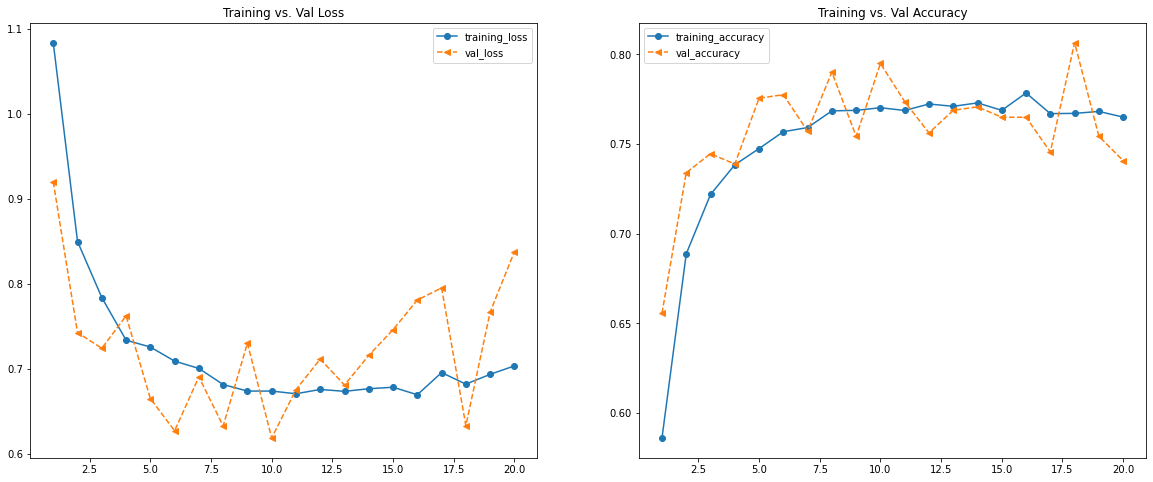

In [18]:
epochs = np.arange(20) + 1

fig, ax = plt.subplots(1, 2, figsize = (20, 8))

ax[0].plot(epochs, hist['loss'], '-o', label = 'training_loss')
ax[0].plot(epochs, hist['val_loss'], '--<', label = 'val_loss')
ax[0].legend()
ax[0].set_title('Training vs. Val Loss')

ax[1].plot(epochs, hist['accuracy'], '-o', label = 'training_accuracy')
ax[1].plot(epochs, hist['val_accuracy'], '--<', label = 'val_accuracy')
ax[1].legend()
ax[1].set_title('Training vs. Val Accuracy')


In [19]:
test_folder = '/kaggle/input/intel-image-classification/seg_test/seg_test/'
ds_filelist_test = tf.data.Dataset.list_files(file_pattern = test_folder + '*/*', shuffle = False)
ds_test = ds_filelist_test.map(load_imgs, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [20]:
ds_test = ds_test.batch(20)

In [21]:
model.evaluate(ds_test)

150/150 [==============================] - 5s 30ms/step - loss: 1.1654 - accuracy: 0.7263


[1.1654438972473145, 0.7263333201408386]

In [22]:
ds_sample = ds_test.unbatch().shuffle(n, reshuffle_each_iteration = False).batch(10).take(1)

In [23]:
pred = model.predict(ds_sample)

In [24]:
pred_prob = tf.nn.softmax(pred, axis = 1)
pred_label = tf.math.argmax(pred_prob, axis = 1)
pred_label_prob = tf.math.reduce_max(pred_prob, axis = 1)

In [25]:
rev_table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(tf.range(6), tf.constant(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])), 'x')
pred_tag = rev_table.lookup(tf.cast(pred_label, tf.int32))

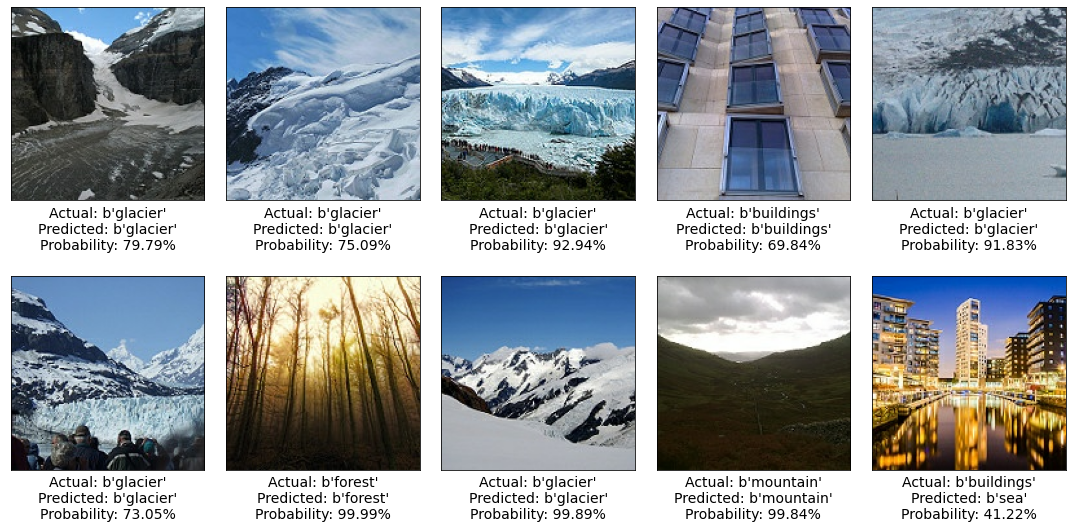

In [26]:
fig = plt.figure(figsize = (15, 8))
for i, sample in enumerate(ds_sample.unbatch()):
    img = sample[0]
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    
    actual_tag = rev_table.lookup(sample[1])
    ax.text(0.5, -0.15, f'Actual: {actual_tag.numpy()}\nPredicted: {pred_tag[i].numpy()}\nProbability: {pred_label_prob[i].numpy():.2%}',
            size = 14, horizontalalignment = 'center', verticalalignment = 'center', transform = ax.transAxes)
    
plt.tight_layout()
plt.show()